#Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from functools import reduce

#Data Preprocessing


The Following function is a function that allows us to plot our data during the processing steps

In [12]:
def plot_column(df, column):
  # Plot 'Produced Energy in kWh'
  plt.figure(figsize=(12, 5))
  plt.plot(df['collect_time'], df[column])
  plt.xlabel("Time")
  plt.ylabel(column)
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# Active Power

In [13]:
def list_files_in_directory(path):
    file_names = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_names.append(os.path.join(root, file))
    return file_names

In [14]:
# Load the CSV file
date_name="2023-09"
start = '2023-09-01 00:00:00'
end = '2023-09-30 23:55:00'

base_dir="/home/jovyan/work/pv-digital-twin"

In [15]:
# Load the CSV file
folder_path = f"{base_dir}/data/Sarafali-CN506/preprocessed/CN506-{date_name}/Inverter" # Update with your actual file path
files = list_files_in_directory(folder_path)

print(files)
# Read and prepare each inverter DataFrame
inverters = [
    pd.read_excel(file, skiprows=3)[['Start Time', 'Active power(kW)']]
      .rename(columns={
          'Start Time': 'collect_time',
          'Active power(kW)': f'active_power_{i}'
      })
      .assign(collect_time=lambda df: pd.to_datetime(df['collect_time'], errors='coerce'))
      .dropna(subset=['collect_time'])
    for i, file in enumerate(files)
]

# Merge all DataFrames on 'collect_time'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='collect_time', how='outer'), inverters)

# Optional cleanup
df = merged_df.sort_values('collect_time').reset_index(drop=True).fillna(0)

# Show result
print(df.head())

['/home/jovyan/work/pv-digital-twin/data/Sarafali-CN506/preprocessed/CN506-2023-09/Inverter/Inverter_6T2259005612_107157798_20230831230000_20230930225959.xlsx', '/home/jovyan/work/pv-digital-twin/data/Sarafali-CN506/preprocessed/CN506-2023-09/Inverter/Inverter_ES2240116177_107157836_20230831230000_20230930225959.xlsx', '/home/jovyan/work/pv-digital-twin/data/Sarafali-CN506/preprocessed/CN506-2023-09/Inverter/Inverter_ES2240121984_107157802_20230831230000_20230930225959.xlsx', '/home/jovyan/work/pv-digital-twin/data/Sarafali-CN506/preprocessed/CN506-2023-09/Inverter/Inverter_ES2240116027_107157796_20230831230000_20230930225959.xlsx', '/home/jovyan/work/pv-digital-twin/data/Sarafali-CN506/preprocessed/CN506-2023-09/Inverter/Inverter_ES2240121983_107157835_20230831230000_20230930225959.xlsx']


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipykernel_4109/1604708742.py:13: FutureWarning: Parsed string "2023-09-01 00:00:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  .assign(collect_time=lambda df: pd.to_datetime(df['collect_time'], errors='coerce'))
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipykernel_4109/1604708742.py:13: FutureWarning: Parsed string "2023-09-01 00:00:00 DST" included an un-recognized timezone "DST". Dropping unrec

         collect_time  active_power_0  active_power_1  active_power_2  \
0 2023-09-01 00:00:00           0.000             0.0             0.0   
1 2023-09-01 06:30:00           0.000             0.0             0.0   
2 2023-09-01 06:35:00           0.000             0.0             0.0   
3 2023-09-01 06:40:00           0.000             0.0             0.0   
4 2023-09-01 06:45:00           0.135             0.0             0.0   

   active_power_3  active_power_4  
0             0.0             0.0  
1             0.0             0.0  
2             0.0             0.0  
3             0.0             0.0  
4             0.0             0.0  


/tmp/ipykernel_4109/1604708742.py:13: FutureWarning: Parsed string "2023-09-01 00:00:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  .assign(collect_time=lambda df: pd.to_datetime(df['collect_time'], errors='coerce'))


In [16]:
def filter_by_date(df, start, end):
    # Parse and normalize datetime column
    df['collect_time'] = pd.to_datetime(df['collect_time'], errors='coerce', utc=False)

    # Remove any timezone information
    df['collect_time'] = df['collect_time'].dt.tz_localize(None)

    # Remove rows with bad dates
    df = df.dropna(subset=['collect_time'])

    return df[(df['collect_time'] >= pd.to_datetime(start)) & (df['collect_time'] <= pd.to_datetime(end))]

def remove_duplicates(df):
    # Remove duplicate timestamps
    return df.drop_duplicates(subset='collect_time')

def interpolate(df, start, end, freq='5min'):
    # Define exact expected range
    full_range = pd.date_range(start=start, end=end, freq=freq)
    df = df.set_index('collect_time')
    df = df.reindex(full_range)

    # Interpolate time-based
    df = df.interpolate(method='linear')

    # Fill edge NaNs
    df = df.fillna(method='ffill').fillna(method='bfill')

    df.index.name = 'collect_time'
    df.reset_index(inplace=True)
    return df

def process_df(df, start, end):
    # Run the full processing pipeline on a single CSV
    df = filter_by_date(df=df, start=start, end=end)
    df = remove_duplicates(df)
    df = interpolate(df=df, start=start, end=end)
    df = df.fillna(0)
    return df

8640
         collect_time  active_power_0  active_power_1  active_power_2  \
0 2023-09-01 00:00:00             0.0             0.0             0.0   
1 2023-09-01 00:05:00             0.0             0.0             0.0   
2 2023-09-01 00:10:00             0.0             0.0             0.0   
3 2023-09-01 00:15:00             0.0             0.0             0.0   
4 2023-09-01 00:20:00             0.0             0.0             0.0   

   active_power_3  active_power_4  
0             0.0             0.0  
1             0.0             0.0  
2             0.0             0.0  
3             0.0             0.0  
4             0.0             0.0  


/tmp/ipykernel_4109/863333738.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


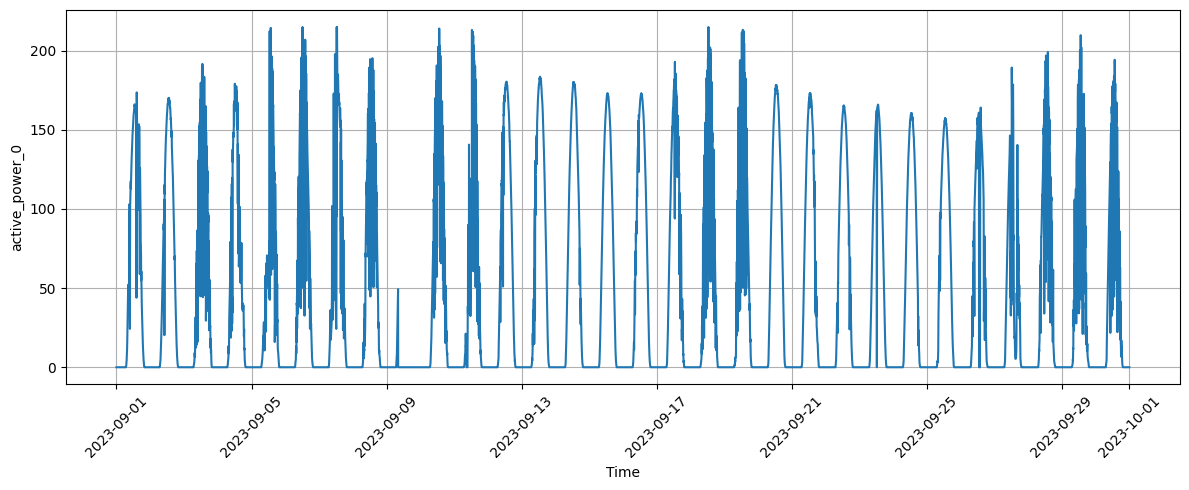

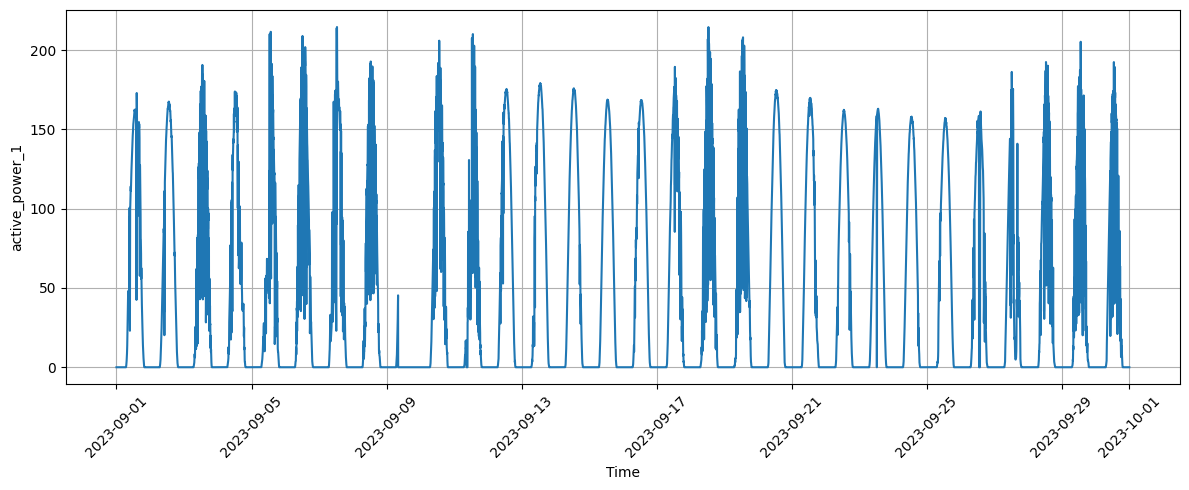

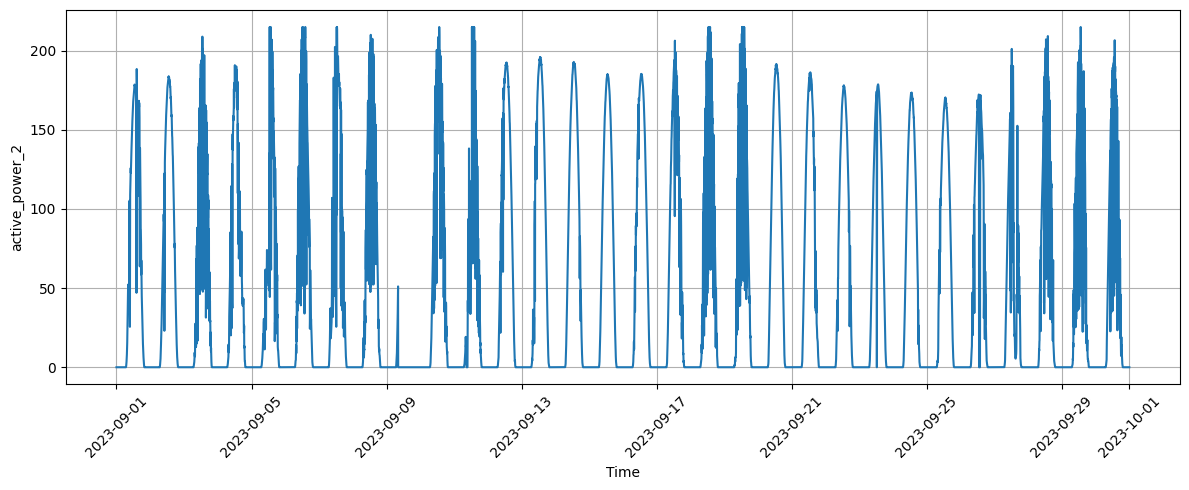

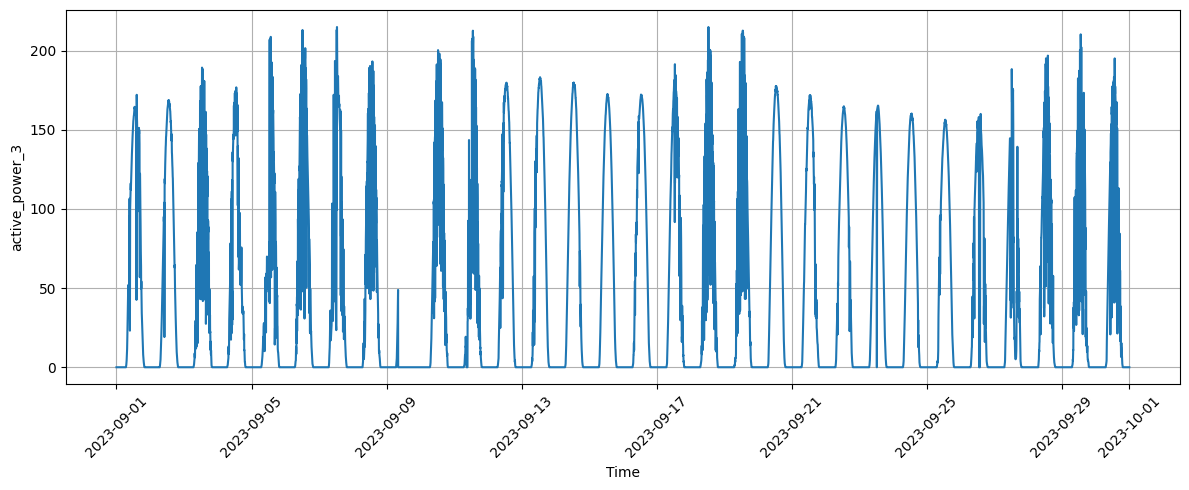

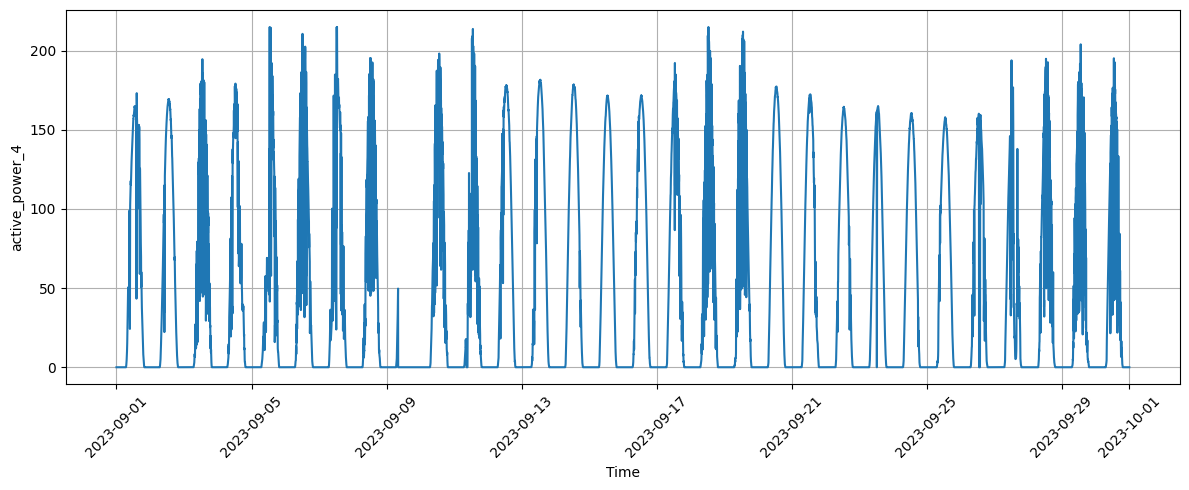

In [17]:
df=process_df(df, start, end)
print(len(df))
print(df.head())
for i in range (5):
  plot_column(df, f'active_power_{i}')

In [18]:
def add_total_active_power(df):
    # Find all columns starting with 'active_power_'
    power_cols = [col for col in df.columns if col.startswith('active_power_')]

    # Create a new column with the row-wise sum
    df['active_power'] = df[power_cols].sum(axis=1)
    df=df[['collect_time', 'active_power']]

    return df

8640
         collect_time  active_power
0 2023-09-01 00:00:00           0.0
1 2023-09-01 00:05:00           0.0
2 2023-09-01 00:10:00           0.0
3 2023-09-01 00:15:00           0.0
4 2023-09-01 00:20:00           0.0


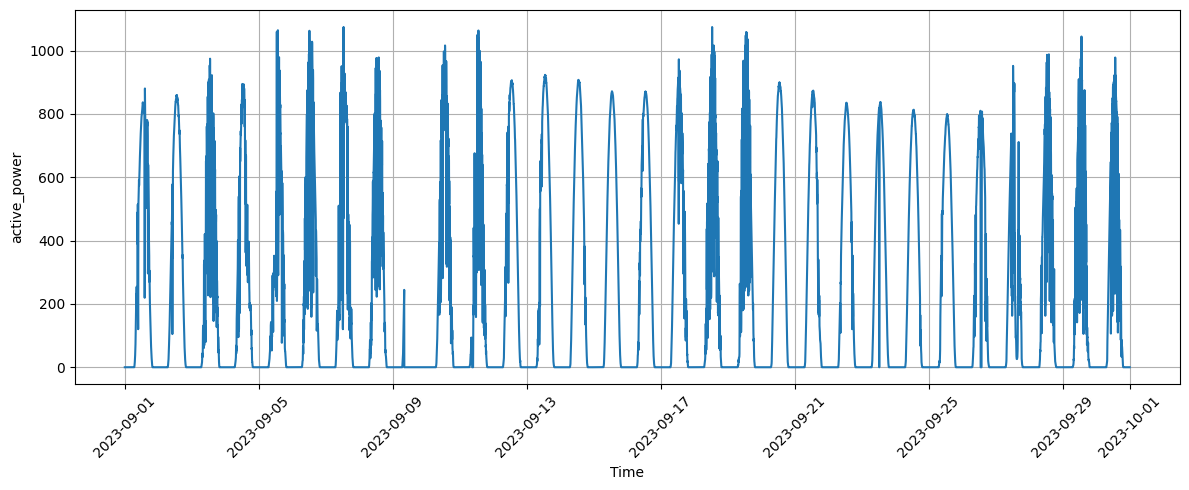

In [19]:
df=add_total_active_power(df)
print(len(df))
print(df.head())
plot_column(df, 'active_power')

In [20]:
active_power_df = df
print(active_power_df.head())
print(len(active_power_df)/288)

         collect_time  active_power
0 2023-09-01 00:00:00           0.0
1 2023-09-01 00:05:00           0.0
2 2023-09-01 00:10:00           0.0
3 2023-09-01 00:15:00           0.0
4 2023-09-01 00:20:00           0.0
30.0


In [ ]:
# Define the range you want to keep
keep1 = (df['collect_time'] < '2024-10-27')
keep1 = df.loc[keep1].copy()

# keep2 = (df['collect_time'] >= '2024-04-27')
# keep2 = df.loc[keep2].copy()

# Define the range you want to copy
mask = (df['collect_time'] >= '2024-10-22') & (df['collect_time'] < '2024-10-27')
copied = df.loc[mask].copy()

# Step 2: Shift the time forward by 4 days
copied['collect_time'] = copied['collect_time'] + pd.Timedelta(days=5)

# Step 3: Append to original dataframe
df_augmented = pd.concat([keep1, copied], ignore_index=True)

# Step 4: Sort by time (important!)
df_augmented = df_augmented.sort_values('collect_time').reset_index(drop=True)


In [ ]:
df_augmented = df.copy()
df_augmented['collect_time'] = df_augmented['collect_time'] - pd.Timedelta(days=31)


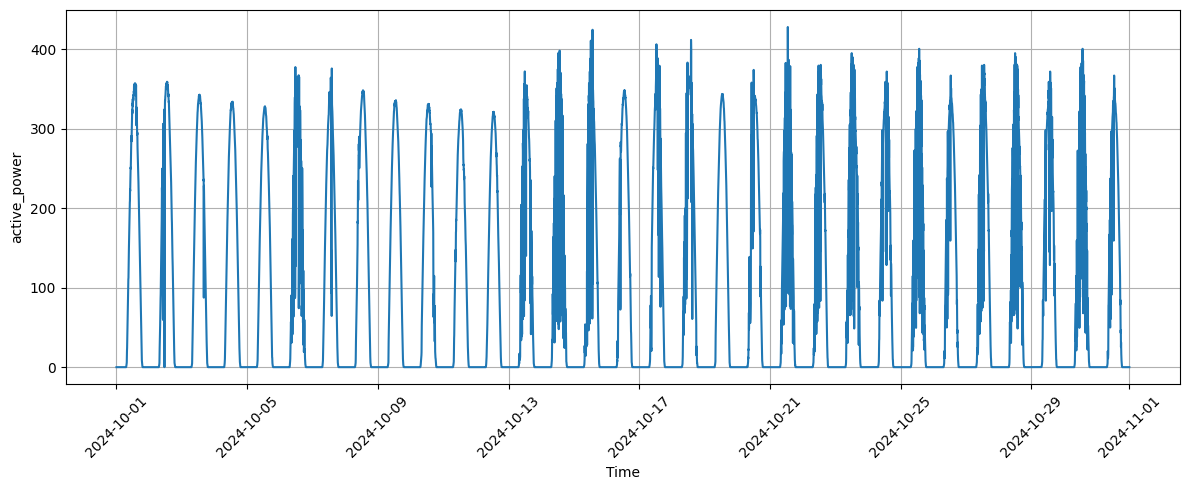

31.0


In [ ]:
plot_column(df_augmented, 'active_power')
print(len(df_augmented)/288)

In [ ]:
df.to_csv(f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/{date_name}.csv", index=False)

In [ ]:
df.to_csv(f"/content/drive/MyDrive/Thesis/Data/Sarafli-CN506/final/active_power.csv", index=False)

# Weather Data

In [21]:
# Load the CSV file
folder_path = f"{base_dir}/data/Sarafali-CN506/preprocessed/CN506-{date_name}/EMI"
files = list_files_in_directory(folder_path)

df=pd.read_excel(files[0], skiprows=3)[['Start Time', 'Ambient temperature(℃)', 'Irradiance(W/㎡)', 'Wind speed(m/s)']]
df=df.rename(columns={'Start Time': 'collect_time', 'Ambient temperature(℃)': 'temperature', 'Irradiance(W/㎡)': 'irradiance', 'Wind speed(m/s)': 'wind_speed'})

# Show result
print(df.head())

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


              collect_time  temperature  irradiance  wind_speed
0  2023-08-31 23:00:00 DST         21.5         0.0         4.6
1  2023-08-31 23:05:00 DST         21.5         0.0         5.5
2  2023-08-31 23:10:00 DST         21.6         0.0         6.7
3  2023-08-31 23:15:00 DST         21.6         0.0         5.0
4  2023-08-31 23:20:00 DST         21.7         0.4         7.6


collect_time    0
temperature     0
irradiance      0
wind_speed      0
dtype: int64
8640
         collect_time  temperature  irradiance  wind_speed
0 2023-09-01 00:00:00         22.3         0.0         4.2
1 2023-09-01 00:05:00         23.1         0.0         5.0
2 2023-09-01 00:10:00         22.8         0.0         2.1
3 2023-09-01 00:15:00         22.4         0.0         3.4
4 2023-09-01 00:20:00         22.2         0.0         3.8


/tmp/ipykernel_4109/863333738.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


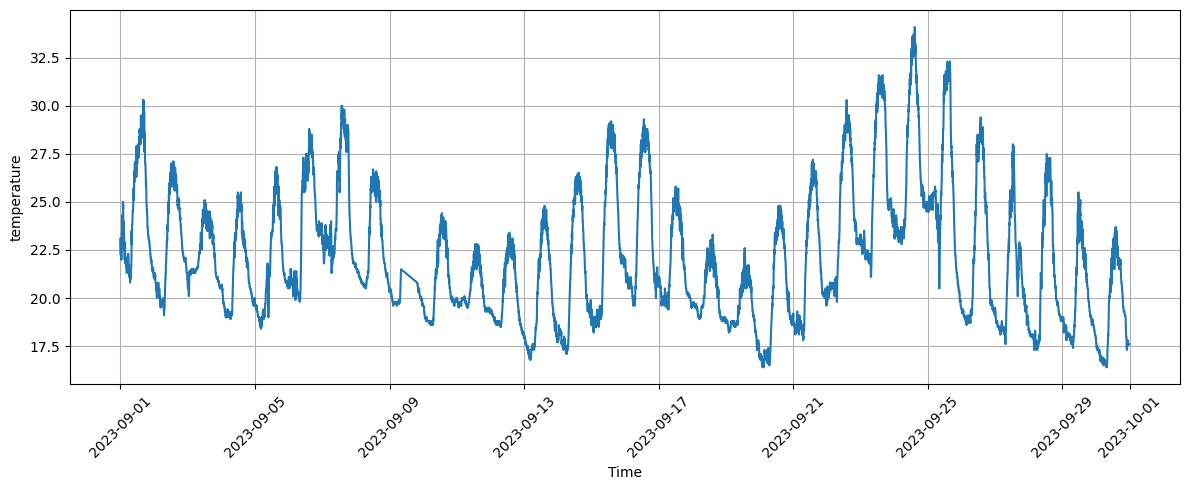

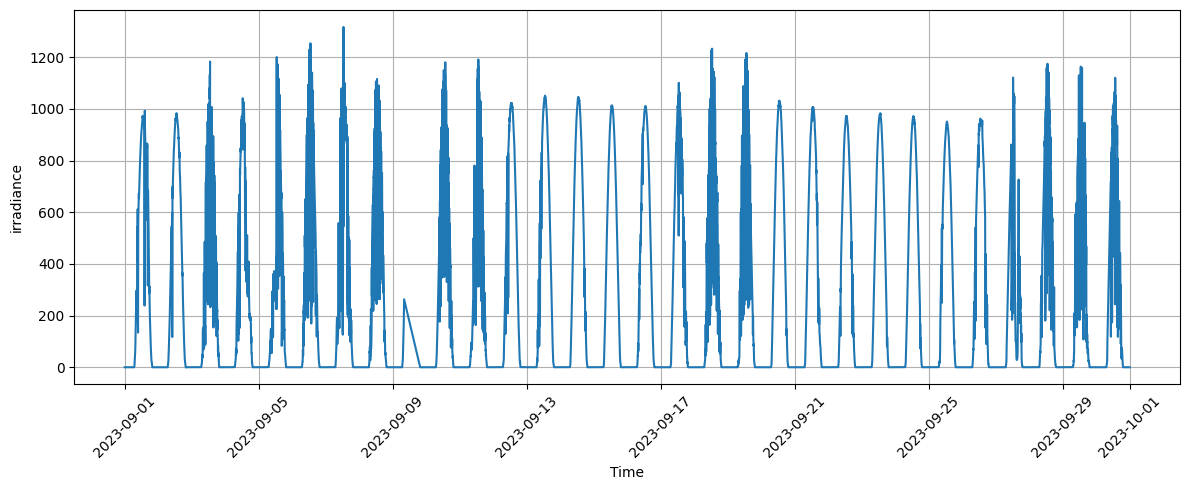

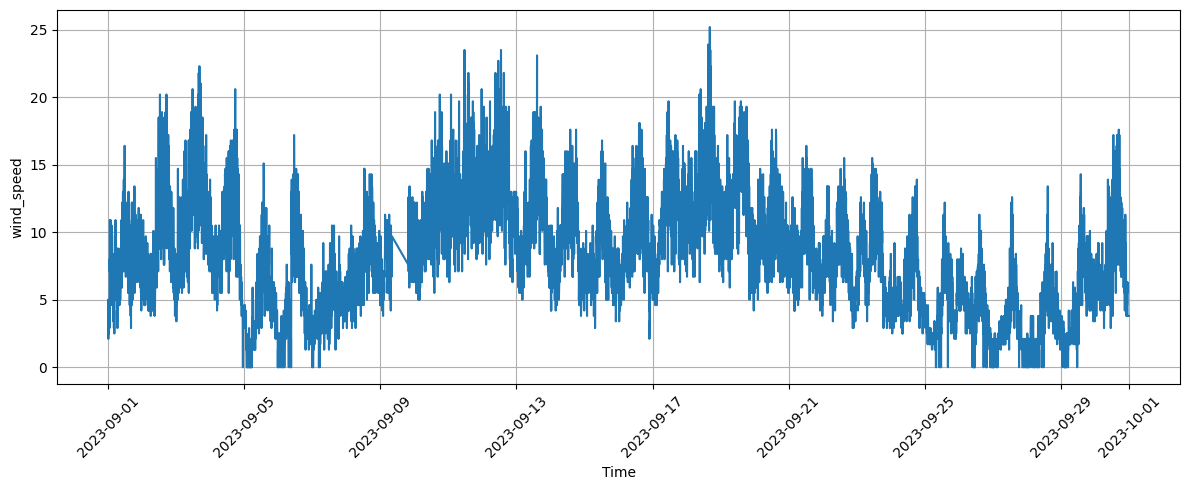

In [23]:
df = filter_by_date(df, start, end)
df = remove_duplicates(df)
df = df[(df['temperature'] > 2) & (df['temperature']< 40)]
# df = df[(df['wind_speed'] > 2)]
df = interpolate(df, start, end)

print(df.isna().sum())

print(len(df))
print(df.head())
plot_column(df, 'temperature')
plot_column(df, 'irradiance')
plot_column(df, 'wind_speed')

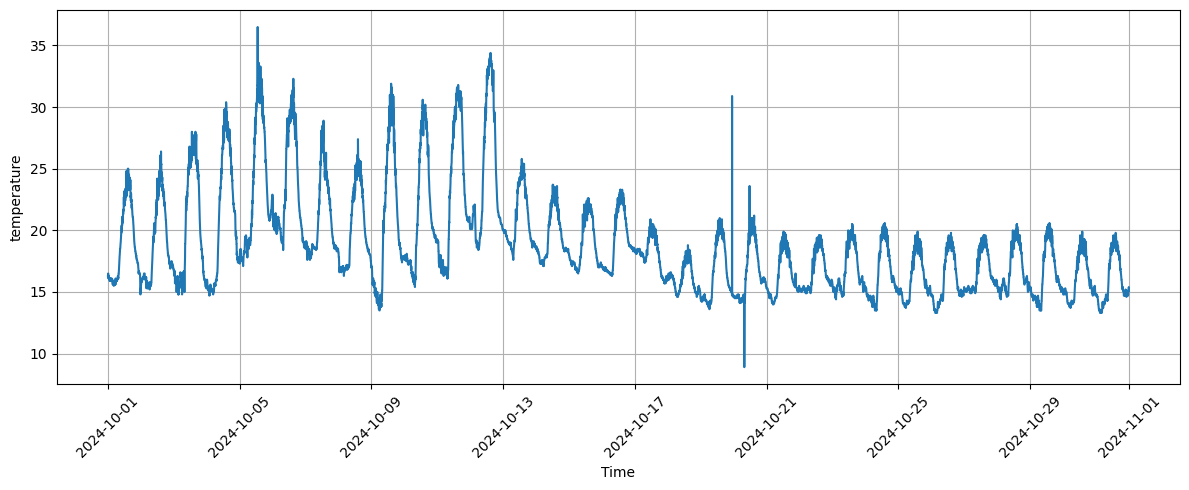

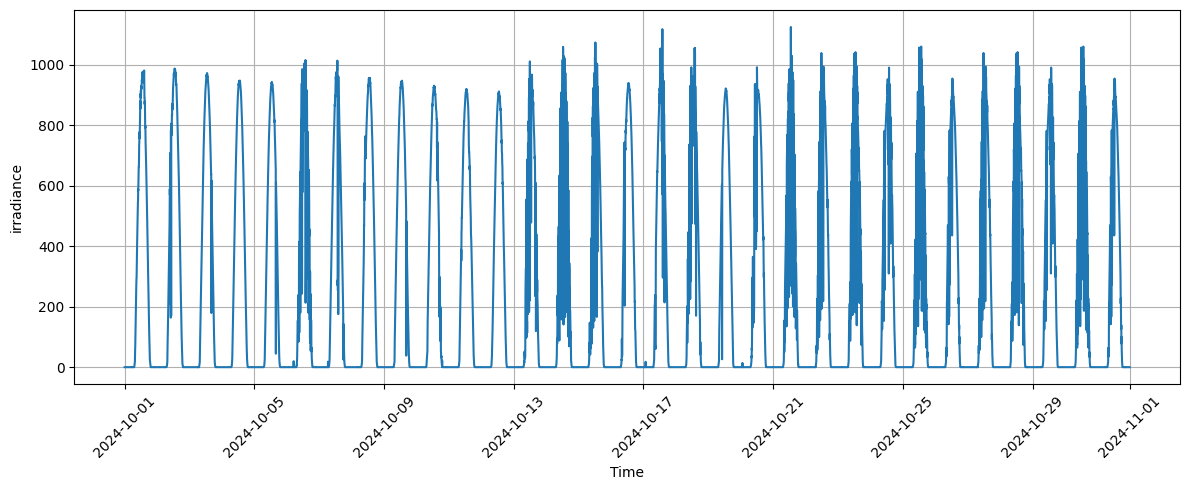

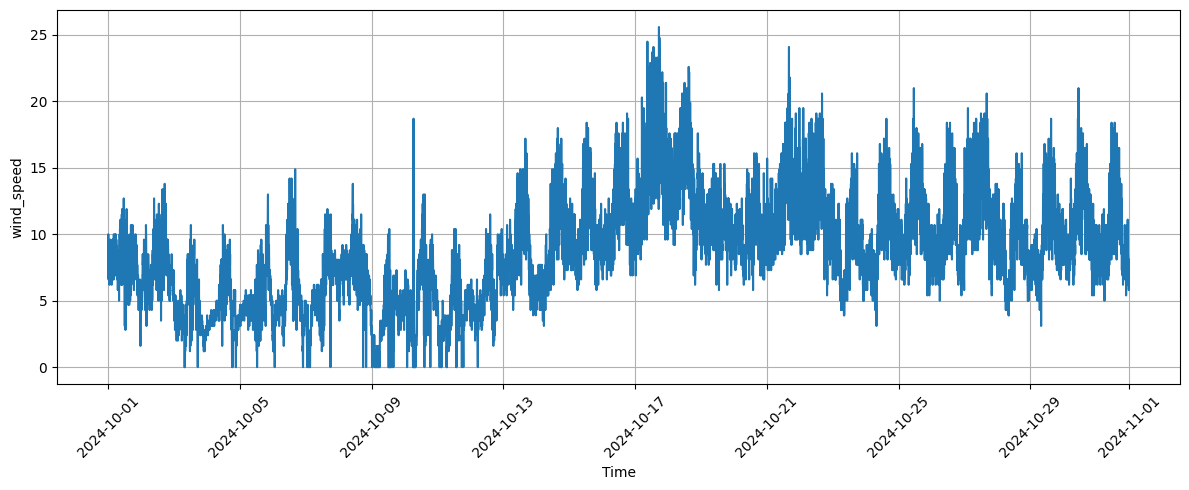

31.0


In [ ]:
plot_column(df_augmented, 'temperature')
plot_column(df_augmented, 'irradiance')
plot_column(df_augmented, 'wind_speed')
print(len(df_augmented)/288)

In [24]:
weather_df = df

print(weather_df.head())
print(len(weather_df)/288)

         collect_time  temperature  irradiance  wind_speed
0 2023-09-01 00:00:00         22.3         0.0         4.2
1 2023-09-01 00:05:00         23.1         0.0         5.0
2 2023-09-01 00:10:00         22.8         0.0         2.1
3 2023-09-01 00:15:00         22.4         0.0         3.4
4 2023-09-01 00:20:00         22.2         0.0         3.8
30.0


In [ ]:
df_augmented.to_csv(f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/weather_data/{date_name}.csv", index=False)

In [27]:
df = pd.merge(weather_df, active_power_df, how='left', on = 'collect_time')
print(df.head())
print(len(df)/288)

df.to_csv(f"{base_dir}/data/Sarafali-CN506/final/station/{date_name}/data.csv", index=False)

         collect_time  temperature  irradiance  wind_speed  active_power
0 2023-09-01 00:00:00         22.3         0.0         4.2           0.0
1 2023-09-01 00:05:00         23.1         0.0         5.0           0.0
2 2023-09-01 00:10:00         22.8         0.0         2.1           0.0
3 2023-09-01 00:15:00         22.4         0.0         3.4           0.0
4 2023-09-01 00:20:00         22.2         0.0         3.8           0.0
30.0


# Merge all months into 1

In [ ]:
folder_path = f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power" # Update with your actual file path
files = list_files_in_directory(folder_path)
files = sorted(files)

active_power = pd.DataFrame()
for file in files:
  df = pd.read_csv(file)
  print(len(df)/288, file)
  # print(df.head())
  active_power = pd.concat([active_power, df], ignore_index=True)

# active_power = active_power.drop_duplicates(subset='collect_time')
print(len(active_power)/288)
print(active_power.head())
active_power.to_csv(f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power.csv", index=False)

20.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2023-08.csv
30.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2023-09.csv
31.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2023-10.csv
30.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2023-11.csv
31.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2023-12.csv
31.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-01.csv
29.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-02.csv
31.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-03.csv
30.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-04.csv
31.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-05.csv
30.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-06.csv
31.0 /content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/active_power/2024-07.csv
31.0 /content/dr

## Retrieve Open-Meteo Data

In [4]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests

import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 35.13,
	"longitude": 25.259,
	"start_date": "2023-08-12",
	"end_date": "2025-01-31",
	"hourly": ["temperature_2m", "wind_speed_10m","shortwave_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant"],
	"timezone": "Europe/Athens",
	"wind_speed_unit": "ms",
	"tilt": 25
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
hourly_shortwave_radiation_instant = hourly.Variables(2).ValuesAsNumpy()
hourly_diffuse_radiation_instant = hourly.Variables(3).ValuesAsNumpy()
hourly_direct_normal_irradiance_instant = hourly.Variables(4).ValuesAsNumpy()
hourly_global_tilted_irradiance_instant = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
hourly_data["diffuse_radiation_instant"] = hourly_diffuse_radiation_instant
hourly_data["direct_normal_irradiance_instant"] = hourly_direct_normal_irradiance_instant
hourly_data["global_tilted_irradiance_instant"] = hourly_global_tilted_irradiance_instant


hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 35.114234924316406°N 25.108280181884766°E
Elevation 476.0 m asl
Timezone b'Europe/Athens'b'GMT+3'
Timezone difference to GMT+0 10800 s
                           date  temperature_2m  wind_speed_10m  \
0     2023-08-11 21:00:00+00:00       19.613001        3.001666   
1     2023-08-11 22:00:00+00:00       19.513000        3.401470   
2     2023-08-11 23:00:00+00:00       19.413000        3.612478   
3     2023-08-12 00:00:00+00:00       19.463001        3.501428   
4     2023-08-12 01:00:00+00:00       19.563002        3.413210   
...                         ...             ...             ...   
12931 2025-01-31 16:00:00+00:00       11.863000        2.676752   
12932 2025-01-31 17:00:00+00:00       10.463000        1.960230   
12933 2025-01-31 18:00:00+00:00        9.513000        1.767767   
12934 2025-01-31 19:00:00+00:00        9.013000        1.769181   
12935 2025-01-31 20:00:00+00:00        8.313000        1.540292   

       shortwave_radiation_instant  diffuse_radi

In [33]:
print(len(hourly_dataframe)/24)
hourly_dataframe.to_csv(f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/open-meteo-data.csv", index=False)

539.0


In [34]:
file_path = f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/open-meteo-data.csv" # Update with your actual file path
df = pd.read_csv(file_path)
print(len(df)/24)

df=df.rename(columns={'date': 'collect_time'})

# Convert to datetime if not already
df['collect_time'] = pd.to_datetime(df['collect_time'])

# Convert to local timezone
df['collect_time'] = df['collect_time'].dt.tz_convert('Europe/Athens')

# Remove tz info(naive time)
df['collect_time'] =df['collect_time'].dt.tz_localize(None)

print(df.head())
print(len(df)/24)

539.0
         collect_time  temperature_2m  wind_speed_10m  \
0 2023-08-12 00:00:00       19.613000        3.001666   
1 2023-08-12 01:00:00       19.513000        3.401470   
2 2023-08-12 02:00:00       19.413000        3.612478   
3 2023-08-12 03:00:00       19.463001        3.501428   
4 2023-08-12 04:00:00       19.563002        3.413210   

   shortwave_radiation_instant  diffuse_radiation_instant  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          0.0                        0.0   

   direct_normal_irradiance_instant  global_tilted_irradiance_instant  
0                               0.0                               0.0  
1                               0.0                               0.0  
2                               0.0                               0.

In [35]:
start = '2023-08-12 00:00:00'
end = '2025-01-31 23:55:00'

In [36]:
df = filter_by_date(df, start, end)
df = remove_duplicates(df)
df = interpolate(df, start, end)

print(df.isna().sum())

print(len(df))
print(df.head())

collect_time                        0
temperature_2m                      0
wind_speed_10m                      0
shortwave_radiation_instant         0
diffuse_radiation_instant           0
direct_normal_irradiance_instant    0
global_tilted_irradiance_instant    0
dtype: int64
155232
         collect_time  temperature_2m  wind_speed_10m  \
0 2023-08-12 00:00:00       19.613000        3.001666   
1 2023-08-12 00:05:00       19.604667        3.034983   
2 2023-08-12 00:10:00       19.596333        3.068300   
3 2023-08-12 00:15:00       19.588000        3.101617   
4 2023-08-12 00:20:00       19.579667        3.134934   

   shortwave_radiation_instant  diffuse_radiation_instant  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          0.0                        0.0   

   d

/tmp/ipython-input-24-863333738.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


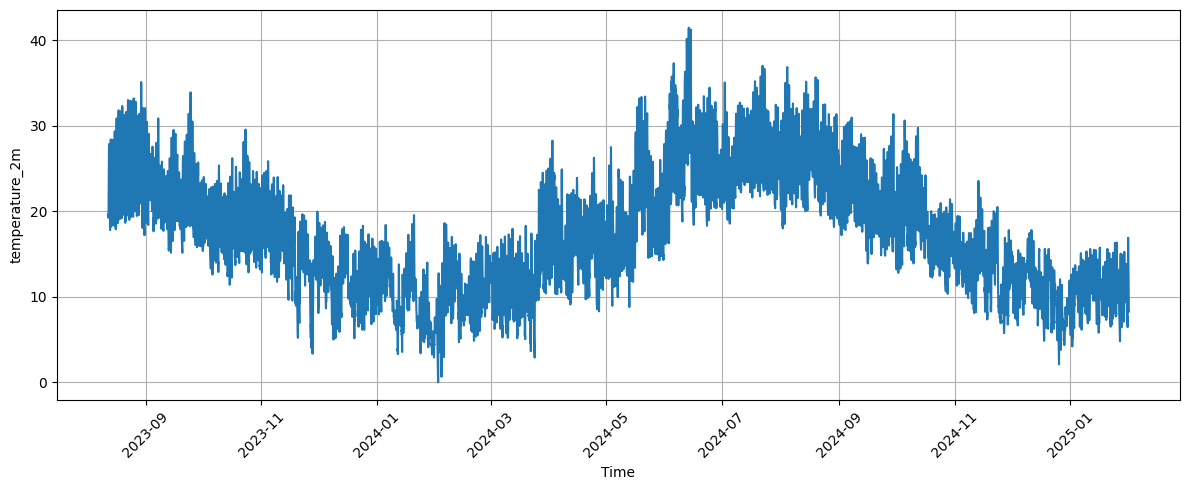

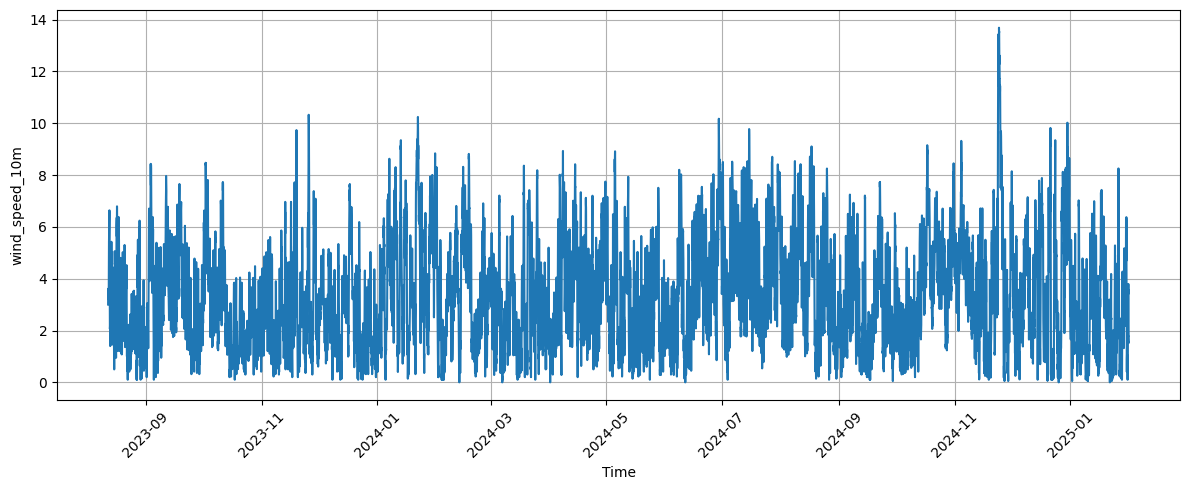

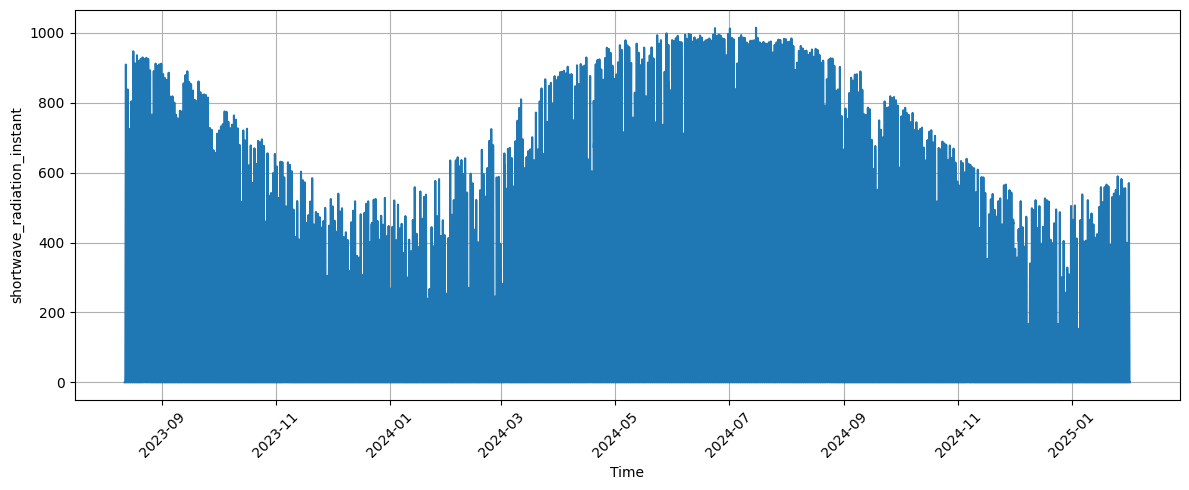

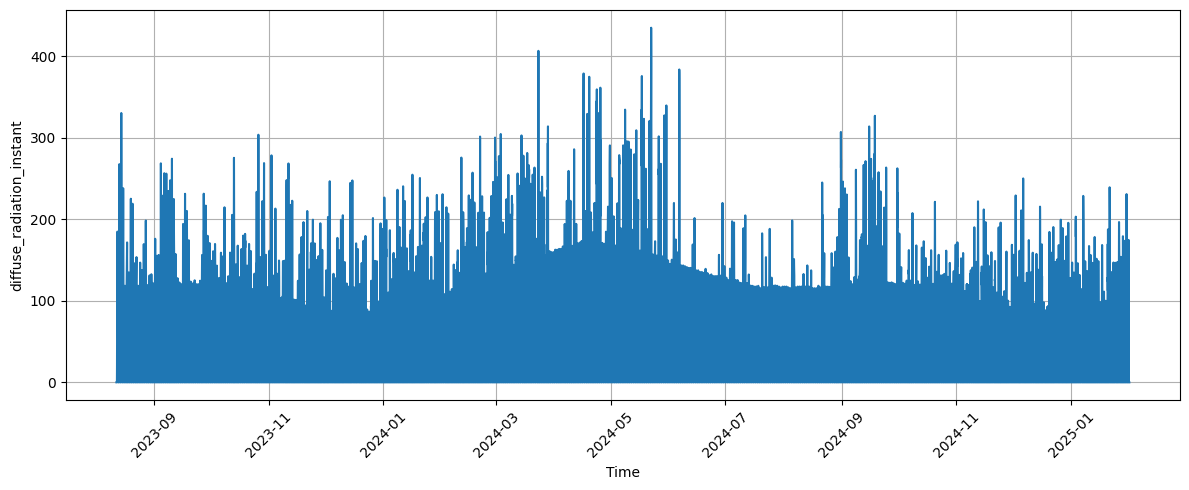

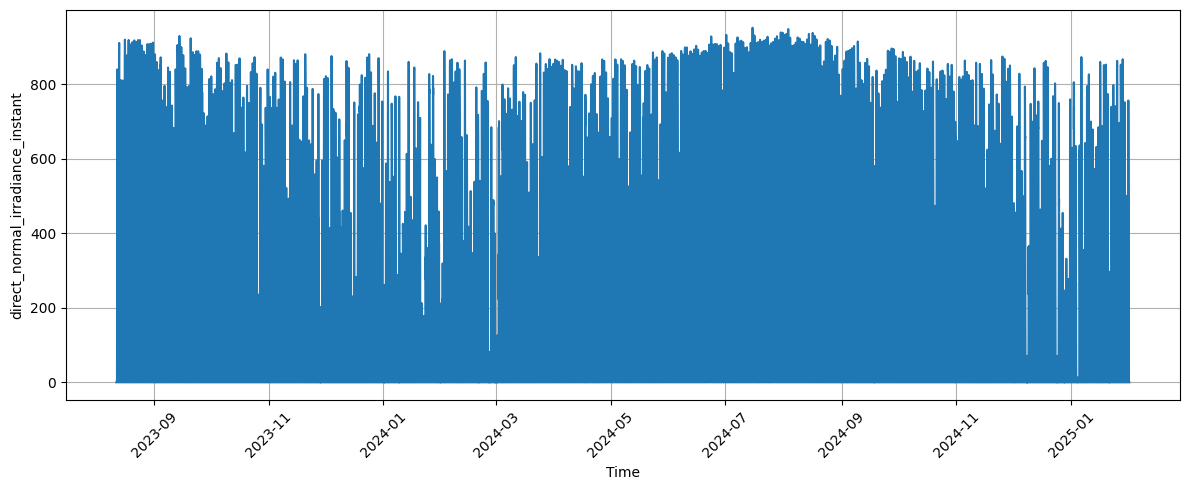

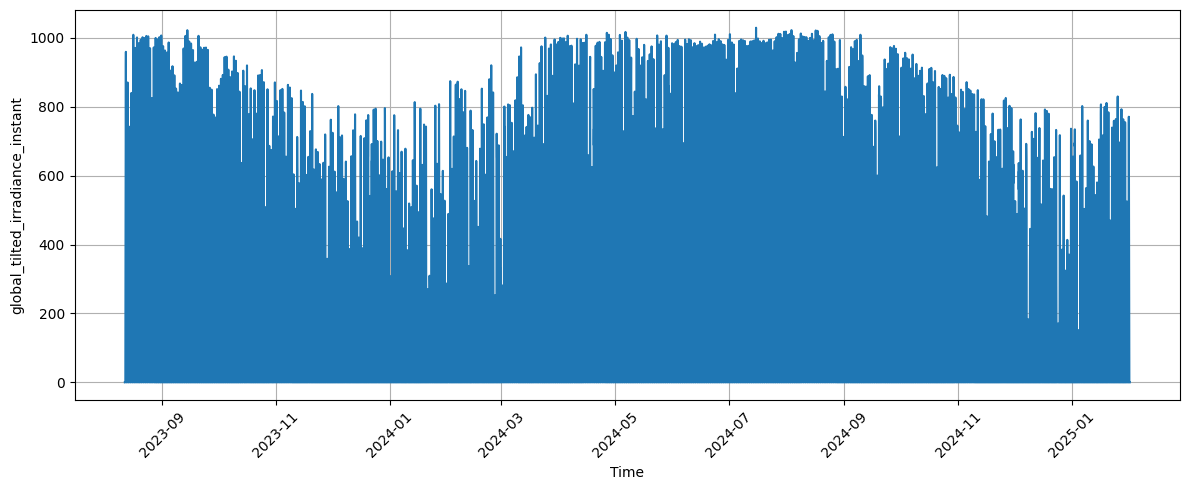

In [38]:
import matplotlib.pyplot as plt
plot_column(df, 'temperature_2m')
plot_column(df, 'wind_speed_10m')
plot_column(df, 'shortwave_radiation_instant')
plot_column(df, 'diffuse_radiation_instant')
plot_column(df, 'direct_normal_irradiance_instant')
plot_column(df, 'global_tilted_irradiance_instant')

In [39]:
print(len(df)/288)
df.to_csv(f"/content/drive/MyDrive/Thesis/Data/Gasi-CN448/final/open-meteo-data.csv", index=False)

539.0
